In [12]:
# Import Libraries
import pandas as pd
import numpy as np
import joblib
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score,
    make_scorer, balanced_accuracy_score
)
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries imported successfully")

Libraries imported successfully


In [13]:
# Load Data (NO SMOTE - Using Class Weights Instead)
df = pd.read_parquet(
    r'C:\Users\Asus\Documents\GitHub\Credit-Scoring\data\data-processing\flat_table\flat_credit_model_20251027_143321.parquet',
    engine="fastparquet"
)

print("="*80)
print("DATA OVERVIEW")
print("="*80)
print(f"Shape: {df.shape}")
print(f"\nClass distribution:")
print(df["TARGET"].value_counts(normalize=True))

# Separate features and target
X = df.drop(columns=["TARGET", "SK_ID_CURR"])
y = df["TARGET"].astype(int)

# Handle missing values
X = X.fillna(0)

print(f"\n✅ Features: {X.shape[1]}")
print(f"✅ Samples: {X.shape[0]}")

DATA OVERVIEW
Shape: (307511, 66)

Class distribution:
TARGET
False    0.919271
True     0.080729
Name: proportion, dtype: float64

✅ Features: 64
✅ Samples: 307511


In [14]:
# Calculate Class Weights (KEY FOR IMBALANCED DATA)
print("="*80)
print("CLASS WEIGHT CALCULATION")
print("="*80)

# Count classes
class_counts = Counter(y)
majority_count = class_counts[0]
minority_count = class_counts[1]

# Calculate imbalance ratio
imbalance_ratio = majority_count / minority_count

# Set scale_pos_weight (weight for minority class)
# Options:
# - Conservative: imbalance_ratio * 1.0
# - Moderate: imbalance_ratio * 1.5
# - Aggressive: imbalance_ratio * 2.0
scale_pos_weight = imbalance_ratio * 4.0

print(f"Class 0 (No Default): {majority_count:,}")
print(f"Class 1 (Default): {minority_count:,}")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")
print(f"scale_pos_weight: {scale_pos_weight:.2f}")
print(f"\n💡 This tells LightGBM to treat Class 1 errors as {scale_pos_weight:.1f}x more important")

CLASS WEIGHT CALCULATION
Class 0 (No Default): 282,686
Class 1 (Default): 24,825
Imbalance ratio: 11.39:1
scale_pos_weight: 45.55

💡 This tells LightGBM to treat Class 1 errors as 45.5x more important


In [15]:
# Define Custom Scoring Metrics
print("="*80)
print("CUSTOM SCORING METRICS FOR CREDIT SCORING")
print("="*80)

# Define multiple scorers for comprehensive evaluation
scoring = {
    'roc_auc': 'roc_auc',
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score),
    'balanced_accuracy': make_scorer(balanced_accuracy_score)
}

print("✅ Metrics defined:")
for metric_name in scoring.keys():
    print(f"  - {metric_name}")

CUSTOM SCORING METRICS FOR CREDIT SCORING
✅ Metrics defined:
  - roc_auc
  - f1
  - precision
  - recall
  - balanced_accuracy


In [18]:
# Setup LightGBM with Class Weights
print("="*80)
print("LIGHTGBM MODEL CONFIGURATION")
print("="*80)

lgb_model = lgb.LGBMClassifier(
    # Core parameters
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,
    
    # Regularization
    min_child_samples=20,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    
    # Sampling
    subsample=0.8,
    subsample_freq=5,
    colsample_bytree=0.8,
    
    # CLASS WEIGHT - KEY FOR IMBALANCED DATA
    scale_pos_weight=scale_pos_weight,

    # Other settings
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Model configured with class weights")
print(f"   scale_pos_weight: {scale_pos_weight:.2f}")

LIGHTGBM MODEL CONFIGURATION
Model configured with class weights
   scale_pos_weight: 45.55


In [19]:
# Stratified K-Fold Cross-Validation
print("="*80)
print("STRATIFIED K-FOLD CROSS-VALIDATION")
print("="*80)

# Setup stratified k-fold (maintains class distribution in each fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print(f"Number of folds: 5")
print(f"Stratified: Yes (maintains {minority_count/(majority_count+minority_count)*100:.1f}% minority class in each fold)")

# Perform cross-validation
print("\n🔄 Running cross-validation...")
cv_results = cross_validate(
    estimator=lgb_model,
    X=X,
    y=y,
    cv=skf,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1,
    verbose=1
)

print("\nCross-validation completed!")

STRATIFIED K-FOLD CROSS-VALIDATION
Number of folds: 5
Stratified: Yes (maintains 8.1% minority class in each fold)

🔄 Running cross-validation...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished



Cross-validation completed!


In [20]:
# Analyze Cross-Validation Results
print("="*80)
print("CROSS-VALIDATION RESULTS")
print("="*80)

# Create results dataframe
cv_summary = pd.DataFrame({
    'Metric': ['ROC-AUC', 'F1-Score', 'Precision', 'Recall', 'Balanced Accuracy'],
    'Train Mean': [
        cv_results['train_roc_auc'].mean(),
        cv_results['train_f1'].mean(),
        cv_results['train_precision'].mean(),
        cv_results['train_recall'].mean(),
        cv_results['train_balanced_accuracy'].mean()
    ],
    'Train Std': [
        cv_results['train_roc_auc'].std(),
        cv_results['train_f1'].std(),
        cv_results['train_precision'].std(),
        cv_results['train_recall'].std(),
        cv_results['train_balanced_accuracy'].std()
    ],
    'Test Mean': [
        cv_results['test_roc_auc'].mean(),
        cv_results['test_f1'].mean(),
        cv_results['test_precision'].mean(),
        cv_results['test_recall'].mean(),
        cv_results['test_balanced_accuracy'].mean()
    ],
    'Test Std': [
        cv_results['test_roc_auc'].std(),
        cv_results['test_f1'].std(),
        cv_results['test_precision'].std(),
        cv_results['test_recall'].std(),
        cv_results['test_balanced_accuracy'].std()
    ]
})

print(cv_summary.to_string(index=False))

# Check for overfitting
print("\n" + "="*80)
print("OVERFITTING CHECK")
print("="*80)
for metric in ['roc_auc', 'f1', 'precision', 'recall']:
    train_mean = cv_results[f'train_{metric}'].mean()
    test_mean = cv_results[f'test_{metric}'].mean()
    gap = train_mean - test_mean
    
    print(f"{metric.upper()}: Train={train_mean:.4f}, Test={test_mean:.4f}, Gap={gap:.4f}")
    if gap > 0.05:
        print(f"  ⚠️ Potential overfitting detected!")
    else:
        print(f"  Good generalization")

CROSS-VALIDATION RESULTS
           Metric  Train Mean  Train Std  Test Mean  Test Std
          ROC-AUC    0.850791   0.000266   0.694005  0.003886
         F1-Score    0.195722   0.000483   0.174889  0.000984
        Precision    0.108512   0.000295   0.096899  0.000539
           Recall    0.996999   0.000158   0.896193  0.006022
Balanced Accuracy    0.638841   0.001113   0.581347  0.002769

OVERFITTING CHECK
ROC_AUC: Train=0.8508, Test=0.6940, Gap=0.1568
  ⚠️ Potential overfitting detected!
F1: Train=0.1957, Test=0.1749, Gap=0.0208
  Good generalization
PRECISION: Train=0.1085, Test=0.0969, Gap=0.0116
  Good generalization
RECALL: Train=0.9970, Test=0.8962, Gap=0.1008
  ⚠️ Potential overfitting detected!


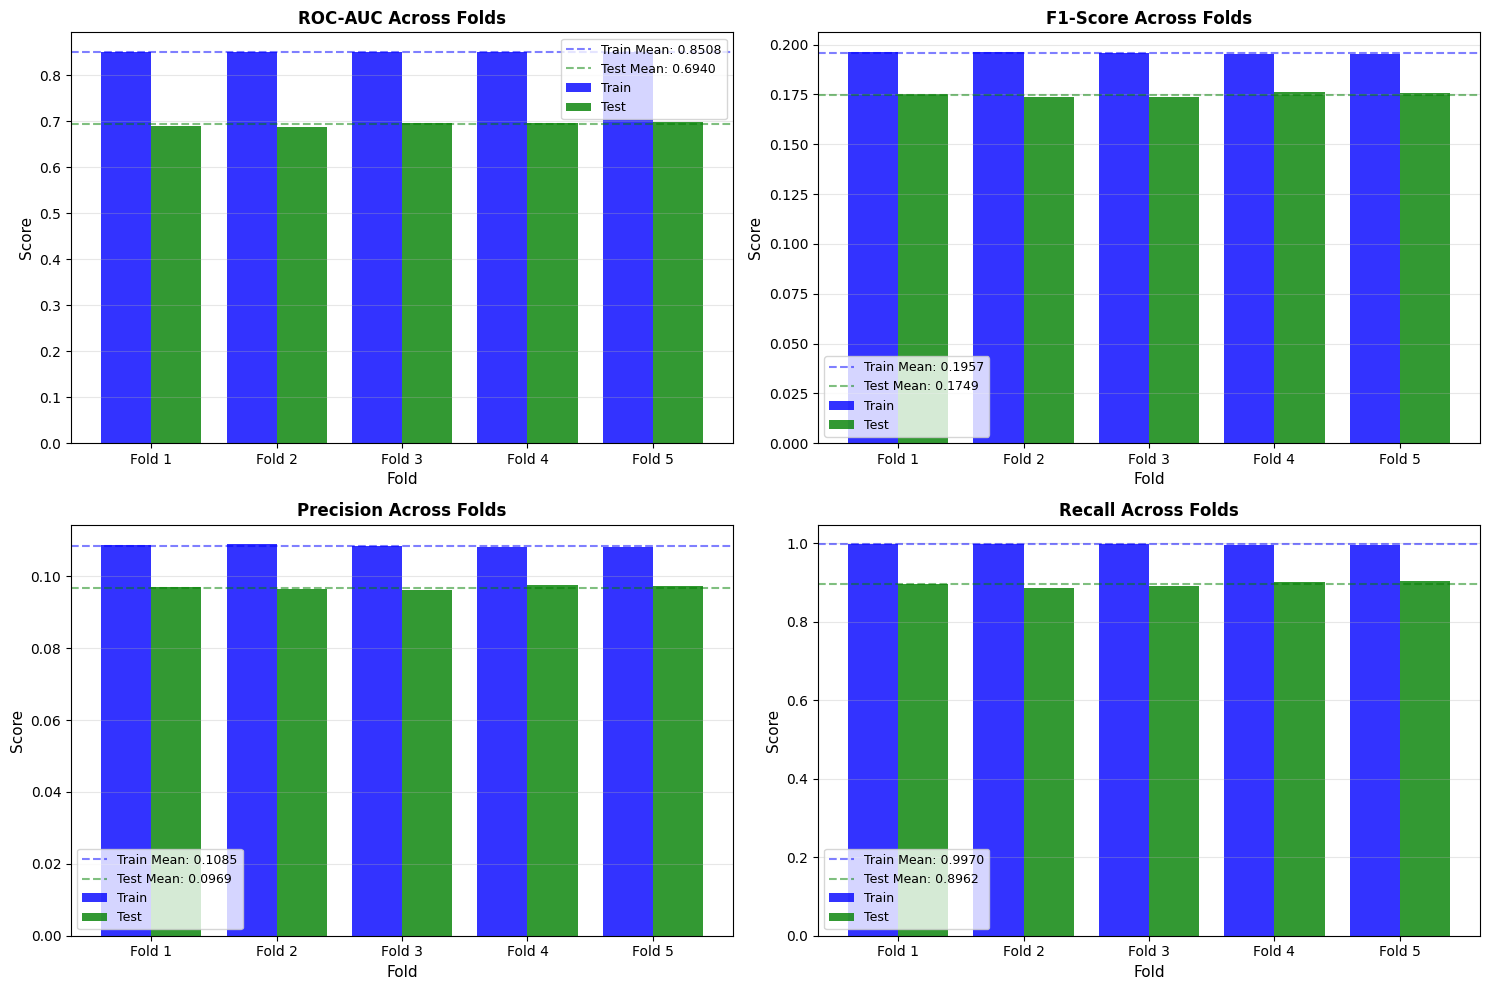

In [21]:
# Visualize Cross-Validation Results
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

metrics_to_plot = ['roc_auc', 'f1', 'precision', 'recall']
metric_names = ['ROC-AUC', 'F1-Score', 'Precision', 'Recall']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    ax = axes[idx // 2, idx % 2]
    
    train_scores = cv_results[f'train_{metric}']
    test_scores = cv_results[f'test_{metric}']
    
    x_pos = np.arange(len(train_scores))
    
    ax.bar(x_pos - 0.2, train_scores, 0.4, label='Train', alpha=0.8, color='blue')
    ax.bar(x_pos + 0.2, test_scores, 0.4, label='Test', alpha=0.8, color='green')
    
    ax.axhline(train_scores.mean(), color='blue', linestyle='--', alpha=0.5, 
               label=f'Train Mean: {train_scores.mean():.4f}')
    ax.axhline(test_scores.mean(), color='green', linestyle='--', alpha=0.5,
               label=f'Test Mean: {test_scores.mean():.4f}')
    
    ax.set_xlabel('Fold', fontsize=11)
    ax.set_ylabel('Score', fontsize=11)
    ax.set_title(f'{name} Across Folds', fontsize=12, fontweight='bold')
    ax.set_xticks(x_pos)
    ax.set_xticklabels([f'Fold {i+1}' for i in range(len(train_scores))])
    ax.legend(fontsize=9)
    ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Train Final Model on Full Dataset
from sklearn.model_selection import train_test_split

print("="*80)
print("TRAINING FINAL MODEL")
print("="*80)

# Split data (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")
print(f"\nClass distribution in train:")
print(pd.Series(y_train).value_counts(normalize=True))

# Train final model
lgb_final = lgb.LGBMClassifier(
    n_estimators=1000,
    learning_rate=0.05,
    num_leaves=31,
    max_depth=6,
    min_child_samples=20,
    min_child_weight=5,
    reg_alpha=0.1,
    reg_lambda=0.1,
    subsample=0.8,
    subsample_freq=5,
    colsample_bytree=0.8,
    scale_pos_weight=scale_pos_weight,
    objective='binary',
    boosting_type='gbdt',
    metric='auc',
    random_state=42,
    n_jobs=-1
)

print("\n🔄 Training final model with early stopping...")
lgb_final.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['auc', 'binary_logloss'],
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)

print(f"\nTraining completed!")
print(f"Best iteration: {lgb_final.best_iteration_}")
print(f"Best AUC: {lgb_final.best_score_['valid_0']['auc']:.4f}")

TRAINING FINAL MODEL
Train size: (246008, 64)
Test size: (61503, 64)

Class distribution in train:
TARGET
0    0.919271
1    0.080729
Name: proportion, dtype: float64

🔄 Training final model with early stopping...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022050 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10280
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 57
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
[100]	valid_0's binary_logloss: 1.28955	valid_0's auc: 0.702235

Training completed!
Best iteration: 1
Best AUC: 0.6397


In [23]:
# Evaluate Final Model with Multiple Metrics
from sklearn.metrics import classification_report, confusion_matrix

print("="*80)
print("FINAL MODEL EVALUATION")
print("="*80)

# Predictions
y_pred = lgb_final.predict(X_test)
y_prob = lgb_final.predict_proba(X_test)[:, 1]

# Calculate all metrics
roc_auc = roc_auc_score(y_test, y_prob)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
balanced_acc = balanced_accuracy_score(y_test, y_pred)

print(f"\n📊 Performance Metrics:")
print(f"  ROC-AUC: {roc_auc:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall: {recall:.4f}")
print(f"  Balanced Accuracy: {balanced_acc:.4f}")

print("\n📋 Detailed Classification Report:")
print(classification_report(y_test, y_pred, 
                          target_names=['No Default (0)', 'Default (1)'],
                          digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = cm.ravel()

print("\n💼 Business Metrics:")
print(f"  True Positives (Caught defaults): {tp:,}")
print(f"  False Negatives (Missed defaults): {fn:,}")
print(f"  False Positives (Rejected good customers): {fp:,}")
print(f"  True Negatives (Approved good customers): {tn:,}")
print(f"\n  Default Detection Rate: {tp/(tp+fn)*100:.2f}%")
print(f"  Precision (When we predict default): {tp/(tp+fp)*100:.2f}%")

# Business cost
business_cost = (fn * 1000) + (fp * 50)
print(f"\n💰 Estimated Business Cost: ${business_cost:,}")

FINAL MODEL EVALUATION

📊 Performance Metrics:
  ROC-AUC: 0.6397
  F1-Score: 0.0000
  Precision: 0.0000
  Recall: 0.0000
  Balanced Accuracy: 0.5000

📋 Detailed Classification Report:
                precision    recall  f1-score   support

No Default (0)     0.9193    1.0000    0.9579     56538
   Default (1)     0.0000    0.0000    0.0000      4965

      accuracy                         0.9193     61503
     macro avg     0.4596    0.5000    0.4790     61503
  weighted avg     0.8451    0.9193    0.8806     61503


💼 Business Metrics:
  True Positives (Caught defaults): 0
  False Negatives (Missed defaults): 4,965
  False Positives (Rejected good customers): 0
  True Negatives (Approved good customers): 56,538

  Default Detection Rate: 0.00%
  Precision (When we predict default): nan%

💰 Estimated Business Cost: $4,965,000


c:\Users\Asus\Documents\GitHub\Credit-Scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\Documents\GitHub\Credit-Scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Asus\Documents\GitHub\Credit-Scoring\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f

In [24]:
target_recall = 0.70

for threshold in np.arange(0.1, 0.9, 0.05):
    y_pred_temp = (y_prob >= threshold).astype(int)
    recall_temp = recall_score(y_test, y_pred_temp)
    
    if recall_temp >= target_recall:
        optimal_threshold = threshold
        print(f"Threshold {threshold:.2f} achieves {recall_temp:.2%} recall")
        break

y_pred_final = (y_prob >= optimal_threshold).astype(int)

Threshold 0.10 achieves 99.80% recall


In [25]:
# Save Model and Results
print("="*80)
print("SAVING MODEL AND RESULTS")
print("="*80)

# Save model
joblib.dump(lgb_final, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lgbm_classweight_cv_model.pkl")

# Save metadata
model_metadata = {
    'model_type': 'LightGBM with Class Weights',
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'approach': 'Class weights (NO SMOTE) + Stratified CV',
    'scale_pos_weight': scale_pos_weight,
    'cv_folds': 5,
    'cv_results': {
        'roc_auc_mean': cv_results['test_roc_auc'].mean(),
        'roc_auc_std': cv_results['test_roc_auc'].std(),
        'f1_mean': cv_results['test_f1'].mean(),
        'f1_std': cv_results['test_f1'].std()
    },
    'test_metrics': {
        'roc_auc': roc_auc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'balanced_accuracy': balanced_acc
    },
    'business_cost': int(business_cost),
    'hyperparameters': lgb_final.get_params()
}

joblib.dump(model_metadata, r"C:\Users\Asus\Documents\GitHub\Credit-Scoring\output\models\lgbm_classweight_cv_metadata.pkl")

print("✅ Model saved: lgbm_classweight_cv_model.pkl")
print("✅ Metadata saved: lgbm_classweight_cv_metadata.pkl")
print("\n🎯 Key Results:")
print(f"  CV ROC-AUC: {cv_results['test_roc_auc'].mean():.4f} ± {cv_results['test_roc_auc'].std():.4f}")
print(f"  Test ROC-AUC: {roc_auc:.4f}")
print(f"  Test F1-Score: {f1:.4f}")

SAVING MODEL AND RESULTS
✅ Model saved: lgbm_classweight_cv_model.pkl
✅ Metadata saved: lgbm_classweight_cv_metadata.pkl

🎯 Key Results:
  CV ROC-AUC: 0.6940 ± 0.0039
  Test ROC-AUC: 0.6397
  Test F1-Score: 0.0000
